# ER Resource Planning

Discrete Event Simulation (DES) is a useful decision making tool that can be applied to situations where resources are limited and where there are queues in the process or system. Using DES, stakeholders can assess simulated outcomes, as measured by specified Key Point Indicators (KPIs), of various scenarios (e.g. different bed capacities or staffing schedules in an emergency room) without having to conduct costly experiments onsite (read more about DES itself [here](https://www.sciencedirect.com/topics/engineering/discrete-event-simulation)).

Nowadays, there are many software that enable not only simulations, but also animations of systems and processes. However, in this Notebook, we will take a look at a DES framework within Python called SimPy. The Notebook is divided into two sections. In the first half, we will take a look at the basic functionalities of SimPy with a simple emergency room (ER) example; in the second half, we will build Python `classes` and objects using SimPy. Through this Notebook, we hope to help provide a basic understanding of some DES software packages do behind the scenes.

## Process-Oriented Modeling

---

Now, let's assume the following for an ER:

- There is only one required resource for each patient: a bed (combined with a doctor).
- There is only one bed (and a doctor) in the ER.
- The ER opens 24/7, although we will only be simulating the first 24 hours.
- The first patient arrives at exactly 12am (midnight).
- After that, approximately 2 patients arrive every hour, which can be modeled with an exponential distribution.
- Each patient uses the bed for approximately 30 minutes, which can also be fitted with an exponential distribution, and
- The patient will always survive, if they get to use the bed (see the doctor); while waiting, however, they can only survive for 10 minutes on average (which, again, can be modeled with an exponential distribution).

Before we begin, please install and import the following packages. If you are running this Notebook on Syzygy, you might still need to "pip install" the `simpy` package by opening a terminal in the virtual evironment.

In [2]:
import simpy as sim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from datetime import timedelta

We will first assign the above information to variables, so that it will be easier for us to change any of the parameters for sensitivity analysis in the future:

In [3]:
cap_bed = 1.0
avg_arr = 2.0 # patients per hour
avg_bed_use = 0.5 # hour per patient
surv_time = 1/6 
sim_time = 24.0

In the SimPy package, simulations are conducted within an `environment`. It would be more convenient to initiate the `environment` right before running the model, so that we always start with a clean or new environment; however, we decided to keep this at the beginning of this Notebook, so that we are clear as to what the variable `env` refers to later on in the various `functions` that we define.

In [4]:
env = sim.Environment()

After the environment is initiated, we can create our `resource`, a bed, within the `environment`: 

In [5]:
bed = sim.Resource(env, capacity=cap_bed)

In the first function, `arrival()`, which we will be defining below, we want the user to pass in three arguments:
- the `environment` of this particular simulation,
- the average number of patient arrivals per hour, and 
- the resource needed for each patient. 

As long as the simulation is still running, this function will continue to operate. The function contains `yield` instead of `return`, which allows it to become a `generator` (read more about Python [`generators`](https://wiki.python.org/moin/Generators). Every time a patient variable (object) is created through this function, the environment is progressed for the randomly simulated amount of interarrival time.

In [6]:
def arrival(env, avg_arr, bed):
    i = 1
    while True:
        # create a patient (p) object using the patient() function
        p = patient(env, 'Patient {:02d}'.format(i), bed, avg_bed_use)
        # load the patient into the processes (schedule) of our environment
        env.process(p)
        # simulate a random interarrival time
        t = np.random.exponential(1/avg_arr)
        i += 1
        # progressed the environment for the simulated interarrival time
        yield env.timeout(t)

The second function, `patient()`, takes in four arguments:
- the `environment`,
- the patient's identification number,
- the required resource (bed), and 
- the average amount of time each patient uses the bed.

Within this function, we first record the arrival time of the patient, and then we request for a bed using the `request()` method of our resource object. The environment is going to progress either until the resource becomes available or until the patient runs out of their 'survival time'. After calculating the wait time, if the patient is still alive, we progress the environment for the patient's diagnosis time.

In [7]:
def patient(env, patient_id, bed, avg_bed_use):
    
    arrive = env.now
    # print arrival time of patient in a time format instead of a float
    print('{}: {} arrived'.format(str(timedelta(hours=round(env.now,2))), patient_id))
    
    # request for the resource and automatically release it afterwards
    with bed.request() as req:
        
        # simulate a random survival time for the patient while waiting
        survival = np.random.exponential(surv_time)
        # Wait till either the resource to become available
        # or the end of the patient's survival time, whichever first
        results = yield req | env.timeout(survival)
        
        # calculate wait time
        wait = env.now - arrive
        
        # if the patient get to use the bed before his/her survival time runs out
        if req in results:
            print('{}: {} waited for {}'.format(str(timedelta(hours=round(env.now,2))), 
                                                patient_id, 
                                                str(timedelta(hours=round(wait,2)))))
            # simulate a random amount of time that the patient uses the bed
            diagnosis = np.random.exponential(avg_bed_use)
            yield env.timeout(diagnosis)
            print('{}: {} is discharged'.format(str(timedelta(hours=round(env.now,2))), patient_id))
        
        else:
            print('{}: {} left us after {}, unfortunately'.format(str(timedelta(hours=round(env.now,2))),
                                                                  patient_id,
                                                                  str(timedelta(hours=round(wait,2)))))

Finally, let's load the patient arrivals into our environment using the `process()` method of our `environment` (read more about SimPy [`processes`](https://simpy.readthedocs.io/en/latest/simpy_intro/basic_concepts.html)), and then we can start the simulation using the `run()` method.

In SimPy, simulations normally start at time 0 (unitless). We can define time units however we want to, although it is good practice to keep it consistent to avoid confusion. In the functions above, we re-formatted the unitless time by passing it into a `timedelta()` function as hours, and displayed it after transforming it into a string using the `str()` function.

In [8]:
env.process(arrival(env, avg_arr, bed))
env.run(until=sim_time)

0:00:00: Patient 01 arrived
0:00:00: Patient 01 waited for 0:00:00
0:06:00: Patient 02 arrived
0:08:24: Patient 03 arrived
0:18:00: Patient 02 left us after 0:12:00, unfortunately
0:28:12: Patient 03 left us after 0:19:48, unfortunately
0:55:12: Patient 04 arrived
0:58:48: Patient 04 left us after 0:03:36, unfortunately
1:12:36: Patient 01 is discharged
2:21:00: Patient 05 arrived
2:21:00: Patient 05 waited for 0:00:00
2:39:00: Patient 05 is discharged
3:11:24: Patient 06 arrived
3:11:24: Patient 06 waited for 0:00:00
3:11:24: Patient 06 is discharged
3:32:24: Patient 07 arrived
3:32:24: Patient 07 waited for 0:00:00
3:45:00: Patient 08 arrived
3:46:12: Patient 08 left us after 0:01:12, unfortunately
3:47:24: Patient 07 is discharged
3:49:48: Patient 09 arrived
3:49:48: Patient 09 waited for 0:00:00
3:50:24: Patient 09 is discharged
4:52:48: Patient 10 arrived
4:52:48: Patient 10 waited for 0:00:00
4:58:48: Patient 10 is discharged
6:31:48: Patient 11 arrived
6:31:48: Patient 11 waited

Ta-da! We just ran our first SimPy simulation. However, you probably have noticed right away that:

1. The output is long and not very readable, even for such a simple simulation, and
2. If we were to create more functions for a more complicated simulation, each function can easily get lost.

In the second half of this Notebook, we are going to use `classes` and `methods` to separate the different processes and objects/entities; we will also visualize a couple of Key Point Indicators (KPIs), so that the simulation results are easier to interpret. `Classes` help us better organize the different methods (functions) by giving them more structure (read more about Python [`class`](https://docs.python.org/3/tutorial/classes.html)). 

## Object-Oriented Modeling

---

We will maintain the same assumptions in our situation as before:

- There is only one required resource for each patient: a bed (combined with a doctor).
- There is only one bed (and a doctor) in the ER.
- The ER opens 24/7, although we will only be simulating the first 24 hours.
- The first patient arrives at exactly 12am (midnight).
- After that, approximately 2 patients arrive every hour, which can be modeled with an exponential distribution.
- Each patient uses the bed for approximately 30 minutes, which can also be fitted with an exponential distribution, and
- The patient will always survive, if they get to use the bed (see the doctor); while waiting, however, they can only survive for 10 minutes on average (which, again, can be modeled with an exponential distribution).

In [9]:
cap_bed = 1.0
avg_arr = 2.0 # patients per hour
surv_time = 1/6
avg_bed_use = 0.5 # hour per patient
sim_time = 24.0

We will define four `classes`: Record, Patient, Bed (Resource), and Model. The Record class is simply created to -- you guessed it -- store global variables and performance metrics of the simulation:

In [28]:
class Record:
    
    # the frequency that we are going to check our simulation
    check_interval = 0.25 
    
    # storage space for KPIs at each check point
    check_time = []
    check_pat_current = [] # total current patients
    check_pat_waiting = [] # current patients waiting
    check_bed_inuse = [] # current number of bed in use
    check_survival = [] # current survival rate
    
    # storage space for each patient's timeline
    record_pat_id = []
    record_time_in = [] 
    record_wait_time = []
    record_time_use_bed = [] # the time when each patient starts using the bed
    record_bed_use = [] # the amount of time each patient uses the bed
    record_time_out = []
    record_survival = [] # binary variable indicating whether the patient survived
    
    # global variables
    count_pat = 0 # total patients throughout the simulation
    pat_waiting = 0 # current number of patients waiting
    pat_current = 0 # total current patients
    survival = 0 # total number of patients who survived
    
    # empty dataframes created for visualization
    results = pd.DataFrame()
    history = pd.DataFrame()

The second and third classes, `Patient` and `Bed`, are also quite simple. The `Patient` class starts with a dictionary that stores all the patients (Python objects); it then initiates a list of attributes for itself, such as arrival time, wait time, and survival time. The `Bed` class simply sets up a resource with a user-specified capacity.

In [29]:
class Patient:
    
    all_patients = {}
    
    def __init__(self, env):
        Record.count_pat += 1
        #attributes
        self.id = Record.count_pat
        self.bed_use = np.random.exponential(avg_bed_use) # the amount of time this patient will use the bed
        self.time_in = env.now # arrival time
        self.time_queue = 0.0 # wait time
        self.time_use_bed = 0.0 # time when this patient starts using the bed
        self.time_out = 0.0 # time when the patient gets discharged
        self.surv_time = np.random.exponential(surv_time) # the amount of time the patient can survive waiting
        self.survival = 1 # binary variable indicating whether this patient survives
        
class Bed:
    
    def __init__(self, env, cap_bed):
        self.bed = sim.Resource(env, capacity=cap_bed)  

The fourth class, the `Model` class, seems to be more complicated, but we can dissect it by looking at each of its methods (which would normally be called functions had they not been included under a class). 

- First, an environment is initiated whenever this class is called (i.e. when a model object is created).
- The second method, `use_bed()`, defines the process of requesting our resource; after requesting for the bed, we record the patient into our global variables and simulate a random survival time for the patient. It then goes through the same process as described in the first half of this Notebook: simulating and recording each patient's attributes, such as wait time, survival time, and survival status.
- The `patient_arrival()` method generates patients (Python objects) as long as the simulation is running, progressing the environment by a randomly simulated interarrival time each time a patient is generated.
- The `check_model()` method is a parallel process to the `patient_arrival()` process, which checks on the global variables following user-specified intervals (defined in `Record` class).
- The `run()` method loads the two parallel processes and initializes the entire simulation process, and finally,
- The `build_report()` and `plot_results()` methods generate visualized representations of the simulation at the end of each run.

In [30]:
class Model:
    
    def __init__(self):
        
        self.env = sim.Environment()
    
    def use_bed(self, pat):
        
        with self.resource_bed.bed.request() as req:
            
            Record.pat_waiting += 1
            Record.pat_current += 1
            
            results = yield req | self.env.timeout(pat.surv_time)
            
            pat.time_use_bed = self.env.now
            pat.time_queue = self.env.now - pat.time_in
            Record.pat_waiting -= 1
            
            if req in results:

                yield self.env.timeout(pat.bed_use)
                pat.time_out = self.env.now
                pat.survival = 1
                Record.pat_current -= 1
                Record.survival += 1
            
            else:
                
                pat.bed_use = 0.0
                pat.time_out = 0.0
                pat.survival = 0
                Record.pat_current -= 1
                
            Record.record_pat_id.append(pat.id)
            Record.record_time_in.append(pat.time_in)
            Record.record_wait_time.append(pat.time_queue)
            Record.record_time_use_bed.append(pat.time_use_bed)
            Record.record_bed_use.append(pat.bed_use)
            Record.record_time_out.append(pat.time_out)
            Record.record_survival.append(pat.survival)
            
    def patient_arrival(self):
        
        while self.env.now < sim_time:
            
            pat = Patient(self.env)
            pat.all_patients[pat.id] = pat
            self.env.process(self.use_bed(pat))
            
            pat_arr_next = np.random.exponential(1/avg_arr)
            yield self.env.timeout(pat_arr_next)
            
    def check_model(self):
        
        while True:
            
            yield self.env.timeout(Record.check_interval)
            
            Record.check_time.append(self.env.now)
            Record.check_pat_waiting.append(Record.pat_waiting)
            Record.check_pat_current.append(Record.pat_current)
            Record.check_survival.append((Record.survival+Record.pat_current)
                                         /Record.count_pat)
            Record.check_bed_inuse.append(self.resource_bed.bed.count)
            
    def run(self):
        
        self.resource_bed = Bed(self.env, cap_bed)
        
        self.env.process(self.patient_arrival())
        self.env.process(self.check_model())
        self.env.run(until=24.0)
        
        self.build_report()
        self.plot_results()
    
    def build_report(self):
        
        Record.results['Time'] = Record.check_time
        Record.results['Current Patients'] = Record.check_pat_current
        Record.results['Waiting Patients'] = Record.check_pat_waiting
        Record.results['Bed in Use'] = Record.check_bed_inuse
        
        Record.history['Patient ID'] = Record.record_pat_id
        Record.history['Time In'] = Record.record_time_in
        Record.history['Wait Time'] = Record.record_wait_time
        Record.history['Bed Start'] = Record.record_time_use_bed
        Record.history['Use Time'] = Record.record_bed_use
        Record.history['Time Out'] = Record.record_time_out
        Record.history['Survival'] = Record.record_survival
        
    def plot_results(self):
        
        fig, ax = plt.subplots(2, 2, figsize=(9,8), dpi=100)
        
        x = Record.record_pat_id
        y = Record.record_wait_time
        ax[0,0].scatter(x, y, marker='x')
        ax[0,0].set_xlabel('Patient ID')
        ax[0,0].set_ylabel('Wait Time')
        ax[0,0].set_title('Wait Time of Each Patient')
        ax[0,0].grid(True, which='both', lw=1, ls='--', c='.75')
        ax[0,0].xaxis.set_major_locator(MaxNLocator(integer=True))
        
        x = Record.check_time
        y = Record.check_pat_waiting
        ax[0,1].plot(x, y, marker='.')
        ax[0,1].set_xlabel('Time')
        ax[0,1].set_ylabel('Patients Waiting')
        ax[0,1].set_title('Patients Waiting at Each Check Point')
        ax[0,1].grid(True, which='both', lw=1, ls='--', c='.75')
        
        x = Record.check_time
        y = Record.check_bed_inuse
        ax[1,0].plot(x, y, marker='.')
        ax[1,0].set_xlabel('Time')
        ax[1,0].set_ylabel('Bed In Use')
        ax[1,0].set_title('Bed In Use at Each Check Point')
        ax[1,0].grid(True, which='both', lw=1, ls='--', c='.75')
        
        x = Record.check_time
        y = Record.check_survival
        ax[1,1].plot(x, y, marker='.', color='red')
        ax[1,1].set_xlabel('Time')
        ax[1,1].set_ylabel('Survival Rate')
        ax[1,1].set_title('Survival Rate at Each Check Point')
        ax[1,1].grid(True, which='both', lw=1, ls='--', c='.75')
        ax[1,1].set_ylim(-0.1, 1.1)
        
        plt.tight_layout(pad=3)
        plt.show()

Now that we have finished defining the classes and their methods, we can finally create an instance of the model and run it!

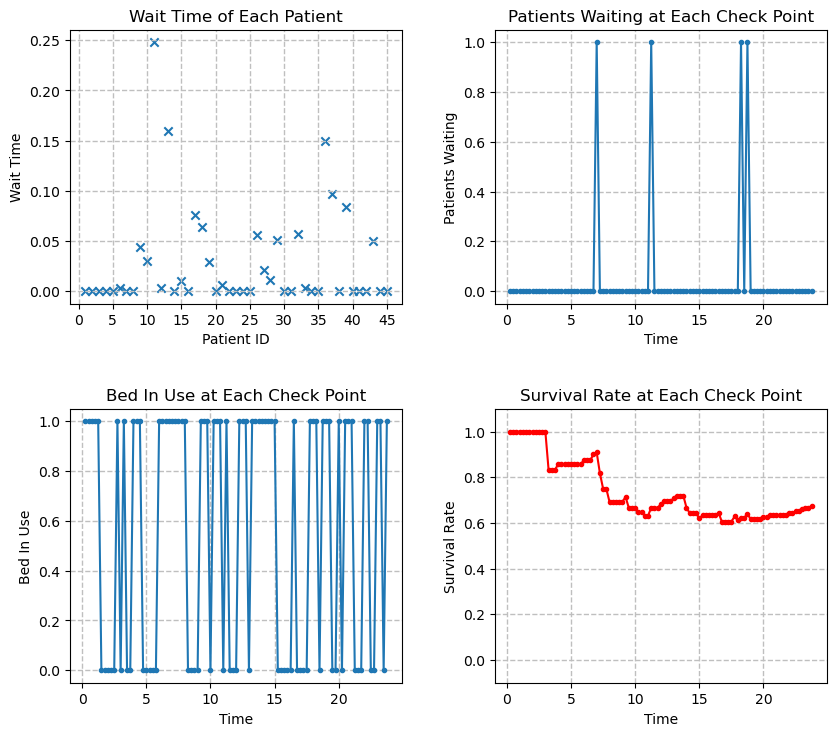

In [31]:
np.random.seed(0) 
# For more informatio on random seeds
# https://numpy.org/devdocs/reference/random/generated/numpy.random.seed.html
model = Model()
model.run()

Next, we want to calculate and display the simulation result statistics:

In [37]:
display(round(Record.history.describe()[['Wait Time', 'Use Time', 'Survival']].drop('count', axis=0),2))

,Wait Time,Use Time,Survival
mean,0.03,0.29,0.67
std,0.05,0.41,0.48
min,0.00,0.00,0.00
25%,0.00,0.00,0.00
50%,0.00,0.09,1.00
75%,0.04,0.44,1.00
max,0.25,1.88,1.00


We can see that the survival rate stabilizes to around 60% after around seven or eight hours, which is something that may be worth exploring, depending on whether you are running Finite-Horizon or Infinite-Horizon DES. Nevertheless, it could be suprising to some that, under the given conditions where around two patients arrive per hour and where each patient uses the bed for approximately 30 minutes, there seems to be long wait times and high fatality rates for patients. Simulations are extremely helpful whenever there are uncertainties, especially in cases like this ER scenario, where the given conditions seem to be reasonable, but actually lead to disastrous outputs. Below is a detailed list of each patient's record:

In [32]:
time_history = Record.history.copy()

time_history[['Time In', 
              'Wait Time', 
              'Bed Start', 
              'Use Time', 
              'Time Out']]=time_history[['Time In', 
                                         'Wait Time', 
                                         'Bed Start', 
                                         'Use Time', 
                                         'Time Out']].apply(lambda x: pd.to_timedelta(round(x,2), unit='h'))

display(time_history)

,Patient ID,Time In,Wait Time,Bed Start,Use Time,Time Out,Survival
0,1,00:00:00,00:00:00,00:00:00,00:24:00,00:24:00,1
1,2,00:27:36,00:00:00,00:27:36,00:23:24,00:51:36,1
2,3,00:58:48,00:00:00,00:58:48,00:17:23.999999,01:16:12,1
3,4,02:38:24,00:00:00,02:38:24,00:14:24,02:52:48,1
4,6,03:03:00,00:00:00,03:03:00,00:00:00,00:00:00,0
5,5,03:00:36,00:00:00,03:00:36,00:25:12,03:25:48,1
6,7,03:57:00,00:00:00,03:57:00,00:45:00,04:42:00,1
7,8,05:52:12,00:00:00,05:52:12,00:48:00,06:40:12,1
8,9,06:37:48,00:02:24,06:40:12,00:03:36,06:43:48,1
9,11,06:58:12,00:15:00,07:13:12,00:00:00,00:00:00,0


## Next Steps

---

Now that you have a basic understanding of how to build a simple Discrete Event Simulation model using SimPy, we encourage you to take it one step further and find out the business implications of the following:

- What is the optimal number of beds in this simulation? You may want to make different assumptions about the cost of each bed/doctor, as well as the value of survival.
- Conduct sensitivity analysis to understand the impact of the changes to some of the existing assumptions, such as:
  - The inter-arrival time of patients (potentially varies depending on time of the day),
  - The amount of time each patient uses the bed (it is most likely right-skewed in reality and should be modeled with a log-normal distribution), and
  - Each patient's survival time (or probability) while waiting and after they see a doctor.
  
## References and Attributions

- Allen, M. (2018). An Emergency Department Model in SimPy, with Patient Prioritization and Capacityy Limited by Doctor Availability (Object-Based). Retrieved from: https://pythonhealthcare.org/2018/07/18/89-an-emergency-department-model-in-simpy-with-patient-prioritisation-and-capacity-limited-by-doctor-availability-object-based/
- Isken, M. (2017). An Object-Oriented SimPy Patient Flow Simulation Model. Retrieved from: http://hselab.org/simpy-first-oo-patflow-model.html